# Step 1:  File Extracting from Local Disk [ Md. Irfanul Kabri Hira]

## Upload two ZIP files:


In [1]:
  from google.colab import files
  uploaded = files.upload()


Saving 377 images for Brian Tumor MRI Images.zip to 377 images for Brian Tumor MRI Images.zip


# Extract them to separate folders

In [2]:
import zipfile

for filename in uploaded.keys():
    foldername = filename.split('.')[0].replace(' ', '_').lower() + "_dataset"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(foldername)
    print(f"✅ Extracted {filename} to {foldername}")

✅ Extracted 377 images for Brian Tumor MRI Images.zip to 377_images_for_brian_tumor_mri_images_dataset


#Inspect extracted folders

In [3]:
import os

# Automatically list all *_dataset folders
dataset_folders = [d for d in os.listdir() if d.endswith('_dataset') and os.path.isdir(d)]

for folder in dataset_folders:
    print(f"\n📁 Inspecting: {folder}")
    for root, dirs, files in os.walk(folder):
        print("📂", root)
        for file in files[:5]:
            print("   └──", file)



📁 Inspecting: 377_images_for_brian_tumor_mri_images_dataset
📂 377_images_for_brian_tumor_mri_images_dataset
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/No_Tumor
   └── N_48.jpg
   └── N_46_HF_.jpg
   └── N_46_SP_.jpg
   └── N_48_HF_.jpg
   └── N_47_DA_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Meningioma
   └── M_882_HF_.jpg
   └── M_881_SP_.jpg
   └── M_881_BR_.jpg
   └── M_881_DA_.jpg
   └── M_881_HF_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Glioma
   └── G_801_BR_.jpg
   └── G_800_RO_.jpg
   └── G_800_SP_.jpg
   └── G_800.jpg
   └── G_806_RO_.jpg
📂 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Pituit

#✅ Phase 1: Data Preparation & Exploratory Setup
#🔹 Step 1: Load & Preprocess Dataset
### [ What we'll do is , load the images from directories, resize them, apply basic transforms, and encode the labels.] Followed By Md. Irfanul kabir Hira

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Define image size (Swin-tiny default is 224x224)
IMG_SIZE = 224
BATCH_SIZE = 16

# Define transforms (you can later add augmentations here)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale MRI
])

# Paths
train_dir = '377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Training'
test_dir = '377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing'

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping
class_names = train_dataset.classes
print("✅ Classes:", class_names)


✅ Classes: ['Glioma', 'Meningioma', 'No_Tumor', 'Pituitary']


#🔹 Step 2: Visualize Sample Images --> (optional but good for inspection) [ Spcially we use this for showing the Sample Images ]

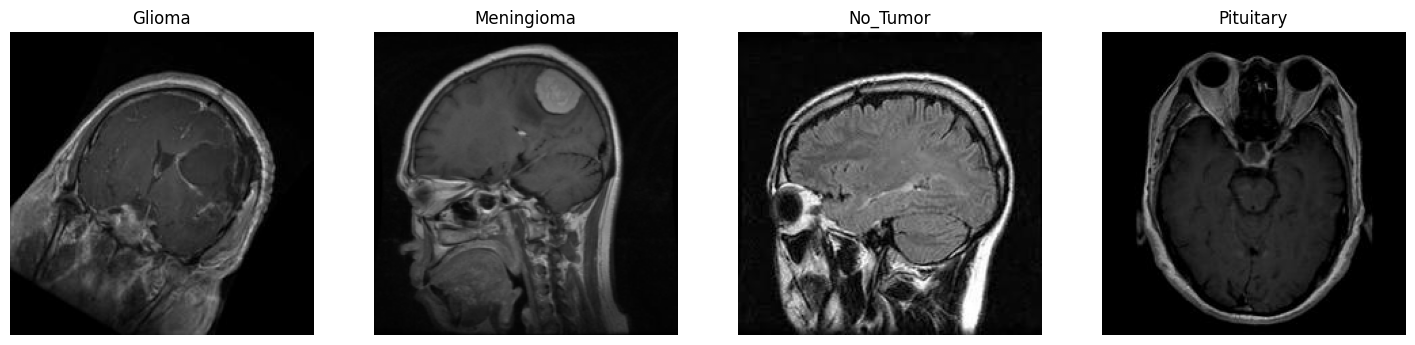

In [6]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')

# Find one image per class
examples = {}
for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == len(class_names):
        break

# Prepare images and titles sorted by label index
imgs = [examples[i] for i in range(len(class_names))]
titles = [class_names[i] for i in range(len(class_names))]

# Show images in one grid
plt.figure(figsize=(18, 4))
for i in range(len(class_names)):
    plt.subplot(1, len(class_names), i + 1)
    imshow(imgs[i], titles[i])
plt.show()


#🔎 Research Proposal Work: Part : 1 Swin Transformer Feature Extraction
#phase 1 : , we’ll Do is:
##    ✅ Load a pretrained Swin Transformer (from timm).
##    ✅ Remove the classification head so it acts as a feature extractor.
##    ✅ Extract patch-level features from your MRI images.

#✅ Step 1: Install Required Libraries

In [7]:
!pip install timm --quiet


#✅ Step 2: Load Pretrained Swin Transformer

In [8]:
import timm
import torch.nn as nn

# Load pretrained Swin Transformer (Tiny version)
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

# Remove classification head
swin_model.head = nn.Identity()

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model = swin_model.to(device)
swin_model.eval()

print("✅ Swin Tiny loaded and ready for feature extraction!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Swin Tiny loaded and ready for feature extraction!


#✅ Step 3: Define Feature Extractor Function

In [9]:
@torch.no_grad()
def extract_features(model, dataloader):
    model.eval()
    features_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.to(device)
        outputs = model(images)  # shape: [batch_size, feature_dim]
        features_list.append(outputs.cpu())
        labels_list.append(labels)

    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return features, labels


#✅ Step 4: Extract Features for Training and Test Data

In [10]:
train_features, train_labels = extract_features(swin_model, train_loader)
test_features, test_labels = extract_features(swin_model, test_loader)

print("🧠 Train feature shape:", train_features.shape)
print("🧪 Test feature shape:", test_features.shape)


🧠 Train feature shape: torch.Size([301, 7, 7, 768])
🧪 Test feature shape: torch.Size([76, 7, 7, 768])


#⚙️ Phase 2: TCN + Classifier Head
#We’ll now:
##    ✅ Build a custom TCN block (with dilated causal convolutions).
##    ✅ Feed Swin features into TCN (treat them as sequential inputs).
##    ✅ Add a Fully Connected + Softmax layer for classification.



#✅ Step 1: Define the TCN Layer

In [11]:
import torch.nn.functional as F

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_ch = input_channels if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


#Reshape Swin Features Properly


In [12]:
train_features, train_labels = extract_features(swin_model, train_loader)
test_features, test_labels = extract_features(swin_model, test_loader)


In [13]:
# Flatten spatial dimensions (7x7 = 49 sequence length)
train_features = train_features.view(train_features.size(0), 49, 768)  # [B, 49, 768]
test_features = test_features.view(test_features.size(0), 49, 768)    # [B, 49, 768]


#✅ Step 2: Full Model — Swin Features → TCN → FC → Softmax

In [14]:
class SwinTCNClassifier(nn.Module):
    def __init__(self, input_dim=768, tcn_channels=[64, 128], num_classes=4):
        super().__init__()

        self.tcn = TCN(
            input_channels=input_dim,
            num_channels=tcn_channels,
            kernel_size=3,
            dropout=0.2
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(tcn_channels[-1], num_classes)
        )

    def forward(self, x):
        # x: [B, Seq_len, C] → [B, C, Seq_len]
        x = x.permute(0, 2, 1)

        x = self.tcn(x)         # [B, C_out, Seq_len]
        out = self.classifier(x)  # [B, num_classes]
        return out


#✅ Step 3: Instantiate Model

In [15]:
num_classes = len(class_names)

model = SwinTCNClassifier(
    input_dim=768,           # from Swin output
    tcn_channels=[64, 128],  # TCN channels
    num_classes=num_classes
).to(device)


#🔹 Step 4: Test the Model

In [16]:
sample_inputs = train_features[:4].to(device)  # shape: [4, 49, 768]
outputs = model(sample_inputs)

print("🔮 Output shape:", outputs.shape)  # should be [4, 4]


🔮 Output shape: torch.Size([4, 4])


#✅ Phase 4: Training & Evaluation
# 🔧 1. Setup for Training

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


#📦 2. Wrap Features into DataLoaders

In [18]:
# Convert features and labels into tensors
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#⚙️ 3. Define Model, Optimizer, Loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTCNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


#🔁 4. Training Loop

In [20]:
epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(y_batch)

    acc = accuracy_score(all_labels, all_preds)
    test_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")


Epoch [1/20] - Loss: 1.3770 | Val Acc: 0.3026
Epoch [2/20] - Loss: 1.3195 | Val Acc: 0.5132
Epoch [3/20] - Loss: 1.2458 | Val Acc: 0.4737
Epoch [4/20] - Loss: 1.1700 | Val Acc: 0.5789
Epoch [5/20] - Loss: 1.0342 | Val Acc: 0.7368
Epoch [6/20] - Loss: 0.8411 | Val Acc: 0.8816
Epoch [7/20] - Loss: 0.6159 | Val Acc: 0.9211
Epoch [8/20] - Loss: 0.3987 | Val Acc: 0.8947
Epoch [9/20] - Loss: 0.2503 | Val Acc: 0.8816
Epoch [10/20] - Loss: 0.1734 | Val Acc: 0.9605
Epoch [11/20] - Loss: 0.1268 | Val Acc: 0.9211
Epoch [12/20] - Loss: 0.0860 | Val Acc: 0.9474
Epoch [13/20] - Loss: 0.0567 | Val Acc: 0.9211
Epoch [14/20] - Loss: 0.0505 | Val Acc: 0.9605
Epoch [15/20] - Loss: 0.0439 | Val Acc: 0.9737
Epoch [16/20] - Loss: 0.0297 | Val Acc: 0.9605
Epoch [17/20] - Loss: 0.0232 | Val Acc: 0.9605
Epoch [18/20] - Loss: 0.0215 | Val Acc: 0.9868
Epoch [19/20] - Loss: 0.0180 | Val Acc: 0.9868
Epoch [20/20] - Loss: 0.0184 | Val Acc: 0.9868


#📈 5. Plot Training Curves

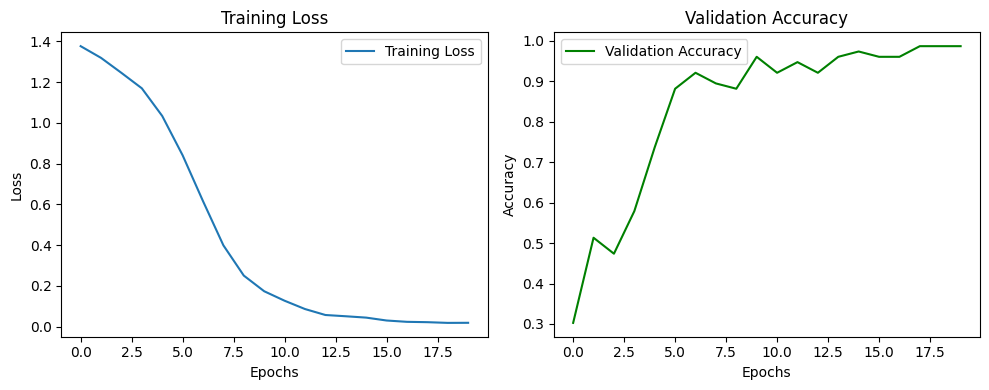

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.show()


#✅ Phase 5: Training: Swin + TCN Hybrid for Brain Tumor Classification


In [22]:
# ✅ TCN-based Classifier Training & Evaluation Pipeline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Prepare Datasets and DataLoaders
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define Model (Reusing SwinTCNClassifier)
class SwinTCNClassifier(nn.Module):
    def __init__(self, input_dim=768, tcn_channels=[64, 128], num_classes=4):
        super().__init__()
        self.tcn = TCN(
            input_channels=input_dim,
            num_channels=tcn_channels,
            kernel_size=3,
            dropout=0.2
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(tcn_channels[-1], num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, Seq_len, C] → [B, C, Seq_len]
        x = self.tcn(x)
        return self.classifier(x)

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTCNClassifier(
    input_dim=768,
    tcn_channels=[64, 128],
    num_classes=len(class_names)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"📚 Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")


📚 Epoch [1/10], Loss: 11.0461
📚 Epoch [2/10], Loss: 3.3575
📚 Epoch [3/10], Loss: 0.7923
📚 Epoch [4/10], Loss: 0.3712
📚 Epoch [5/10], Loss: 0.5657
📚 Epoch [6/10], Loss: 0.1909
📚 Epoch [7/10], Loss: 0.0626
📚 Epoch [8/10], Loss: 0.1125
📚 Epoch [9/10], Loss: 0.0822
📚 Epoch [10/10], Loss: 0.0531
✅ Test Accuracy: 89.47%


## ✅ 1. 🔄 Confusion Matrix + Classification Report + Visualization

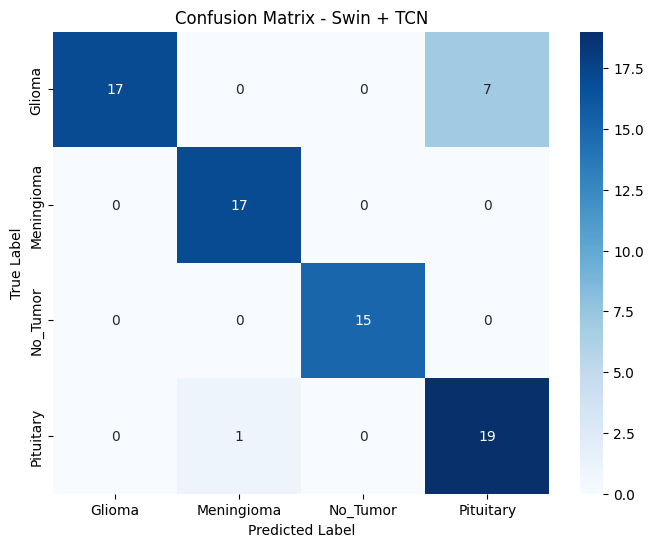

📊 Classification Report:

              precision    recall  f1-score   support

      Glioma       1.00      0.71      0.83        24
  Meningioma       0.94      1.00      0.97        17
    No_Tumor       1.00      1.00      1.00        15
   Pituitary       0.73      0.95      0.83        20

    accuracy                           0.89        76
   macro avg       0.92      0.91      0.91        76
weighted avg       0.92      0.89      0.89        76



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Swin + TCN")
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


#✅ 2. 🧠 Save the Trained Model

In [24]:
torch.save(model.state_dict(), "swin_tcn_classifier.pth")
print("✅ Model saved as 'swin_tcn_classifier.pth'")


✅ Model saved as 'swin_tcn_classifier.pth'


#✅ 3. 📉 Loss Curve (Track + Plot)

##Step A: Modify your training loop to track loss




In [25]:
train_losses = []  # <--- Add this before your loop

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # <--- Track it here

    print(f"📚 Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


📚 Epoch [1/10], Loss: 0.0185
📚 Epoch [2/10], Loss: 0.0023
📚 Epoch [3/10], Loss: 0.0009
📚 Epoch [4/10], Loss: 0.0006
📚 Epoch [5/10], Loss: 0.0004
📚 Epoch [6/10], Loss: 0.0002
📚 Epoch [7/10], Loss: 0.0002
📚 Epoch [8/10], Loss: 0.0002
📚 Epoch [9/10], Loss: 0.0002
📚 Epoch [10/10], Loss: 0.0001


##Step B: Now plot it

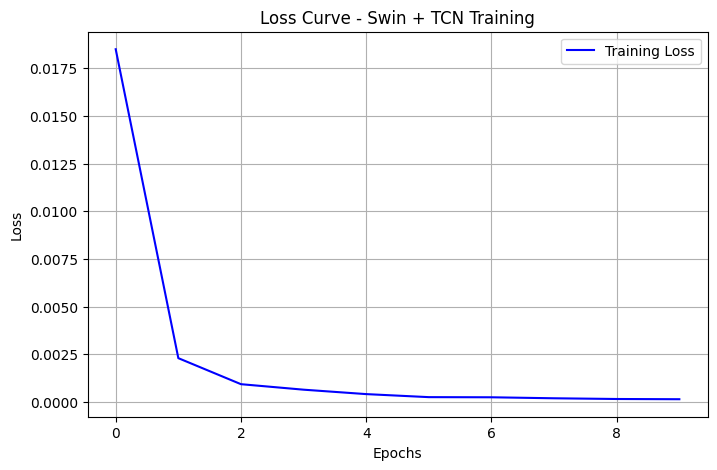

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve - Swin + TCN Training")
plt.legend()
plt.grid(True)
plt.show()


#🚀 Phase 6 – Explainability (XAI)
##his will involve:
##    🎯 Grad-CAM: Visual heatmaps from Swin feature maps
##    🎯 SHAP: Feature-wise impact on the classifier output
##    🎯 (Optional) LIME if needed for more local interpretability

#✅ Phase 6 – XAI (Explainable AI) with Grad-CAM + SHAP


#🧠 Part A: Grad-CAM for Visual Explanation (CNN-like part — Swin + TCN)
## Since Swin and TCN aren’t natively CNN-based, we need a Grad-CAM workaround, especially for Swin layers. We'll use the last convolutional feature before classification to highlight important image regions.
### ✅ Steps:

###    Register hook on TCN’s final convolutional layer (tcn.network[-3]).
###    Forward pass a single image.
###    Backward on target class.
###    Compute Grad-CAM.
###    Visualize the heatmap over the original image.

#✅ Grad-CAM Visual Explanation Code:
## This is adapted specifically for our Swin + TCN model structure:
###🔑 Challenge:
###Grad-CAM is designed for CNNs.

###Swin and TCN don't use traditional 2D convs, but we can simulate Grad-CAM using the last TCN block before the classifier.

#✅ Step 1: Register Hook to Extract Gradients & Activations

In [27]:
# Global variables to store gradients and activations
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output


#✅ Step 2: Register Hooks on Final TCN Layer

In [28]:
# Register hooks on final TCN block
target_layer = model.tcn.network[-1]
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)


#✅ Step 3: Grad-CAM Logic (Forward + Backward Pass)

In [29]:
def generate_gradcam(model, input_tensor, target_class):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)  # shape [1, 49, 768]

    # Forward
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()

    # Backward on chosen class
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Compute weights and Grad-CAM map
    weights = torch.mean(gradients, dim=2).squeeze()  # [C]
    cam = torch.sum(weights.view(-1, 1) * activations.squeeze(), dim=0)  # [Seq_len]
    cam = torch.relu(cam)

    # Normalize
    cam -= cam.min()
    cam /= cam.max()

    return cam.cpu().detach().numpy(), pred_class


#✅ Step 4: Visualize Grad-CAM as Heatmap Overlay

In [30]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import numpy as np

def visualize_gradcam(cam, original_image_path):
    # Resize CAM back to 7x7 spatial layout
    cam_img = cam.reshape(7, 7)
    cam_img = np.uint8(255 * cam_img)

    # Load original image
    orig = Image.open(original_image_path).convert('RGB').resize((224, 224))
    orig_np = np.array(orig)

    # Resize CAM to match image
    cam_resized = Image.fromarray(cam_img).resize((224, 224), resample=Image.BILINEAR)
    cam_resized_np = np.array(cam_resized)

    # Overlay heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(orig_np)
    plt.imshow(cam_resized_np, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()


In [31]:
print(type(test_dataset))
print(dir(test_dataset))  # Lists all available attributes/methods


<class 'torch.utils.data.dataset.TensorDataset'>
['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'tensors']


In [32]:
# Unpack the tensors (images and labels)
image_tensors, label_tensors = test_dataset.tensors


In [33]:
# Print first 50 image paths and labels from test_dataset
for i in range(50):
    label = label_tensors[i].item()
    print(f"Index: {i}, Label: {class_names[label]}")


Index: 0, Label: Glioma
Index: 1, Label: Glioma
Index: 2, Label: Glioma
Index: 3, Label: Glioma
Index: 4, Label: Glioma
Index: 5, Label: Glioma
Index: 6, Label: Glioma
Index: 7, Label: Glioma
Index: 8, Label: Glioma
Index: 9, Label: Glioma
Index: 10, Label: Glioma
Index: 11, Label: Glioma
Index: 12, Label: Glioma
Index: 13, Label: Glioma
Index: 14, Label: Glioma
Index: 15, Label: Glioma
Index: 16, Label: Glioma
Index: 17, Label: Glioma
Index: 18, Label: Glioma
Index: 19, Label: Glioma
Index: 20, Label: Glioma
Index: 21, Label: Glioma
Index: 22, Label: Glioma
Index: 23, Label: Glioma
Index: 24, Label: Meningioma
Index: 25, Label: Meningioma
Index: 26, Label: Meningioma
Index: 27, Label: Meningioma
Index: 28, Label: Meningioma
Index: 29, Label: Meningioma
Index: 30, Label: Meningioma
Index: 31, Label: Meningioma
Index: 32, Label: Meningioma
Index: 33, Label: Meningioma
Index: 34, Label: Meningioma
Index: 35, Label: Meningioma
Index: 36, Label: Meningioma
Index: 37, Label: Meningioma
Inde

In [34]:
from torchvision.transforms import ToPILImage
from PIL import Image

# Access first item
img_tensor, label = test_dataset[31]

# Convert tensor to PIL image
to_pil = ToPILImage()
img = to_pil(img_tensor)

# Show "fake" path (since no real path exists in TensorDataset)
print(f"🚫 Image Path: Not available (TensorDataset)")
print(f"✅ Class Label: {class_names[label]}")
print(f"✅ Image Size: {img.size}")

# Show image
img.show()


🚫 Image Path: Not available (TensorDataset)
✅ Class Label: Meningioma
✅ Image Size: (768, 49)


#✅ Step 5: Run Full Grad-CAM Flow (Split Swin + TCN)

# For Glioma which is in index 0

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


✅ Predicted Class Index: 0 | Name: Glioma


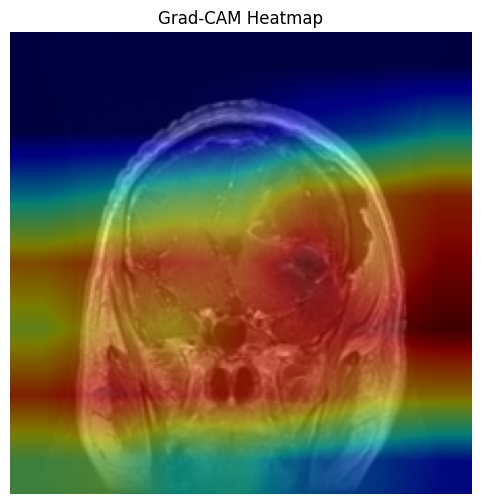

In [35]:
import torch
from torchvision import transforms
from transformers import SwinModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# === Load Swin ===
swin_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model.eval().to(device)

# === Load image ===
image_path = "377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing/Glioma/G_800.jpg"
img = Image.open(image_path).convert("RGB").resize((224, 224))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
img_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 224, 224]

# === Extract Features using Swin ===
with torch.no_grad():
    swin_out = swin_model(pixel_values=img_tensor).last_hidden_state  # [1, 49, 768]

# === Pass to TCN + Classifier ===
model.eval()
with torch.no_grad():
    preds = model(swin_out)  # SwinTCNClassifier expects (B, Seq, C)

# === Grad-CAM (manually call hook or simulate) ===
target_class = class_names.index("Glioma")
cam, pred_class = generate_gradcam(model, swin_out.squeeze(0), target_class)

# === Visualization ===
print(f"✅ Predicted Class Index: {pred_class} | Name: {class_names[pred_class]}")
visualize_gradcam(cam, image_path)


## For Meningeoma which is in index 1

In [36]:
import torch
from torchvision import transforms
from transformers import SwinModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# === Load Swin ===
swin_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model.eval().to(device)

# === Load image ===
image_path = "377_images_for_brian_tumor_mri_images_(6)_dataset/377 images for Brian Tumor MRI Images/Testing/Meningioma/M_881_BR_.jpg"
img = Image.open(image_path).convert("RGB").resize((224, 224))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
img_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 224, 224]

# === Extract Features using Swin ===
with torch.no_grad():
    swin_out = swin_model(pixel_values=img_tensor).last_hidden_state  # [1, 49, 768]

# === Pass to TCN + Classifier ===
model.eval()
with torch.no_grad():
    preds = model(swin_out)  # SwinTCNClassifier expects (B, Seq, C)

# === Grad-CAM (manually call hook or simulate) ===
target_class = class_names.index("Meningioma")  # 👈 use the correct class index
cam, _ = generate_gradcam(model, swin_out.squeeze(0), target_class)

# === Visualization ===
print(f"🎯 Visualizing Grad-CAM for Target Class Index: {target_class} | Name: {class_names[target_class]}")
visualize_gradcam(cam, image_path)



FileNotFoundError: [Errno 2] No such file or directory: '377_images_for_brian_tumor_mri_images_(6)_dataset/377 images for Brian Tumor MRI Images/Testing/Meningioma/M_881_BR_.jpg'

#✅ Step 6: Evaluate Grad-CAM on Multiple Images (Optional but Useful)

#✅ Step 6 — Full Code: Loop Through Test Dataset with CAM

##✅ Load multiple real images from file paths
##✅ Run them through Swin → TCN → Classifier
##✅ Generate Grad-CAM
##✅ Show the prediction and overlay heatmap per image
##✅ Do it for N real image files (not from TensorDataset)

[0] ✅ True: Glioma | Predicted: Pituitary
[1] ✅ True: Glioma | Predicted: Glioma
[2] ✅ True: Glioma | Predicted: Glioma
[3] ✅ True: Glioma | Predicted: Glioma
[4] ✅ True: Glioma | Predicted: Glioma
[5] ✅ True: Glioma | Predicted: Glioma


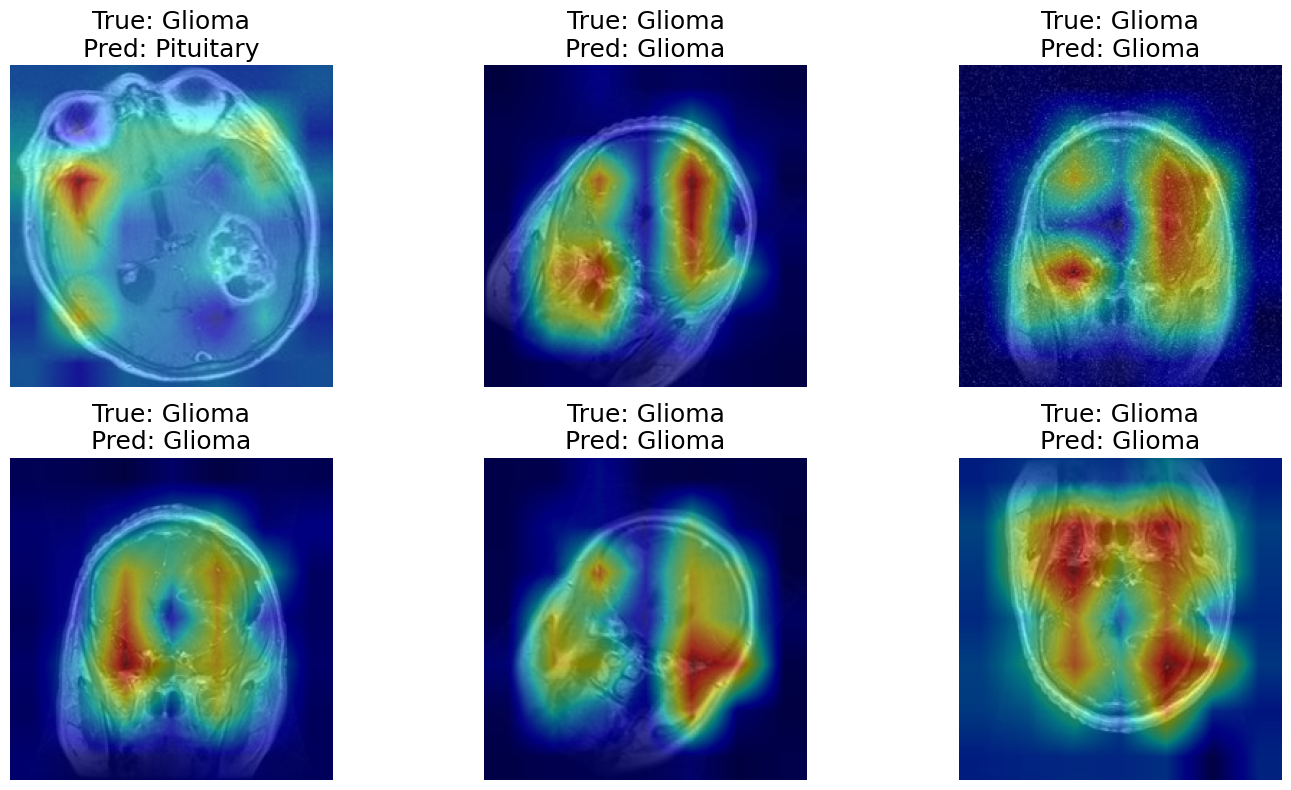

In [37]:
import os
import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
image_dir = "377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing"
N = 6  # Total images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Swin Transformer ===
swin_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model.eval().to(device)

# === Transform ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Image Paths & Labels ===
class_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]
image_paths = []

for class_name in class_names:
    class_folder = os.path.join(image_dir, class_name)
    for img_file in os.listdir(class_folder):
        if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append((os.path.join(class_folder, img_file), class_names.index(class_name)))

image_paths = image_paths[:N]

# === Grad-CAM function ===
def generate_gradcam(model, features, class_idx):
    features = features.unsqueeze(0)  # [1, 49, 768]
    features.requires_grad_(True)

    outputs = model(features)
    score = outputs[0, class_idx]

    model.zero_grad()
    score.backward(retain_graph=True)

    grads = features.grad
    pooled_grads = torch.mean(grads, dim=1)  # [1, 768]
    weighted_feats = features[0] * pooled_grads[0].unsqueeze(0)  # [49, 768]

    cam = torch.sum(weighted_feats, dim=1).cpu().detach().numpy()  # [49]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-5)
    return cam.reshape(7, 7), outputs.argmax(dim=1).item()

# === Grad-CAM overlay visualization (returns image) ===
def get_overlay(cam, img_pil, alpha=0.5):
    cam_resized = Image.fromarray((cam * 255).astype(np.uint8)).resize(img_pil.size, resample=Image.BILINEAR)
    cam_np = np.array(cam_resized)

    cmap = plt.get_cmap('jet')
    heatmap = cmap(cam_np / 255.0)[:, :, :3]

    img_np = np.array(img_pil).astype(np.float32) / 255.0
    overlay = heatmap * alpha + img_np * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    return overlay

# === Run and store overlays for grid ===
overlays = []
titles = []

for i, (path, label_idx) in enumerate(image_paths):
    img = Image.open(path).convert("RGB").resize((224, 224))
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        swin_out = swin_model(pixel_values=img_tensor).last_hidden_state

    model.eval()
    with torch.no_grad():
        preds = model(swin_out)

    cam, pred_idx = generate_gradcam(model, swin_out.squeeze(0), class_idx=preds.argmax(dim=1).item())

    print(f"[{i}] ✅ True: {class_names[label_idx]} | Predicted: {class_names[pred_idx]}")
    overlay = get_overlay(cam, img)
    overlays.append(overlay)
    titles.append(f"True: {class_names[label_idx]}\nPred: {class_names[pred_idx]}")

# === Display in 2x3 Grid ===
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i in range(N):
    axs[i].imshow(overlays[i])
    axs[i].set_title(titles[i], fontsize=18)  # Increased font size to 18
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# same thigs for different Classes

[0] ✅ True: Glioma | Predicted: Pituitary
[1] ✅ True: Meningioma | Predicted: Meningioma
[2] ✅ True: No_Tumor | Predicted: No_Tumor
[3] ✅ True: Pituitary | Predicted: Pituitary


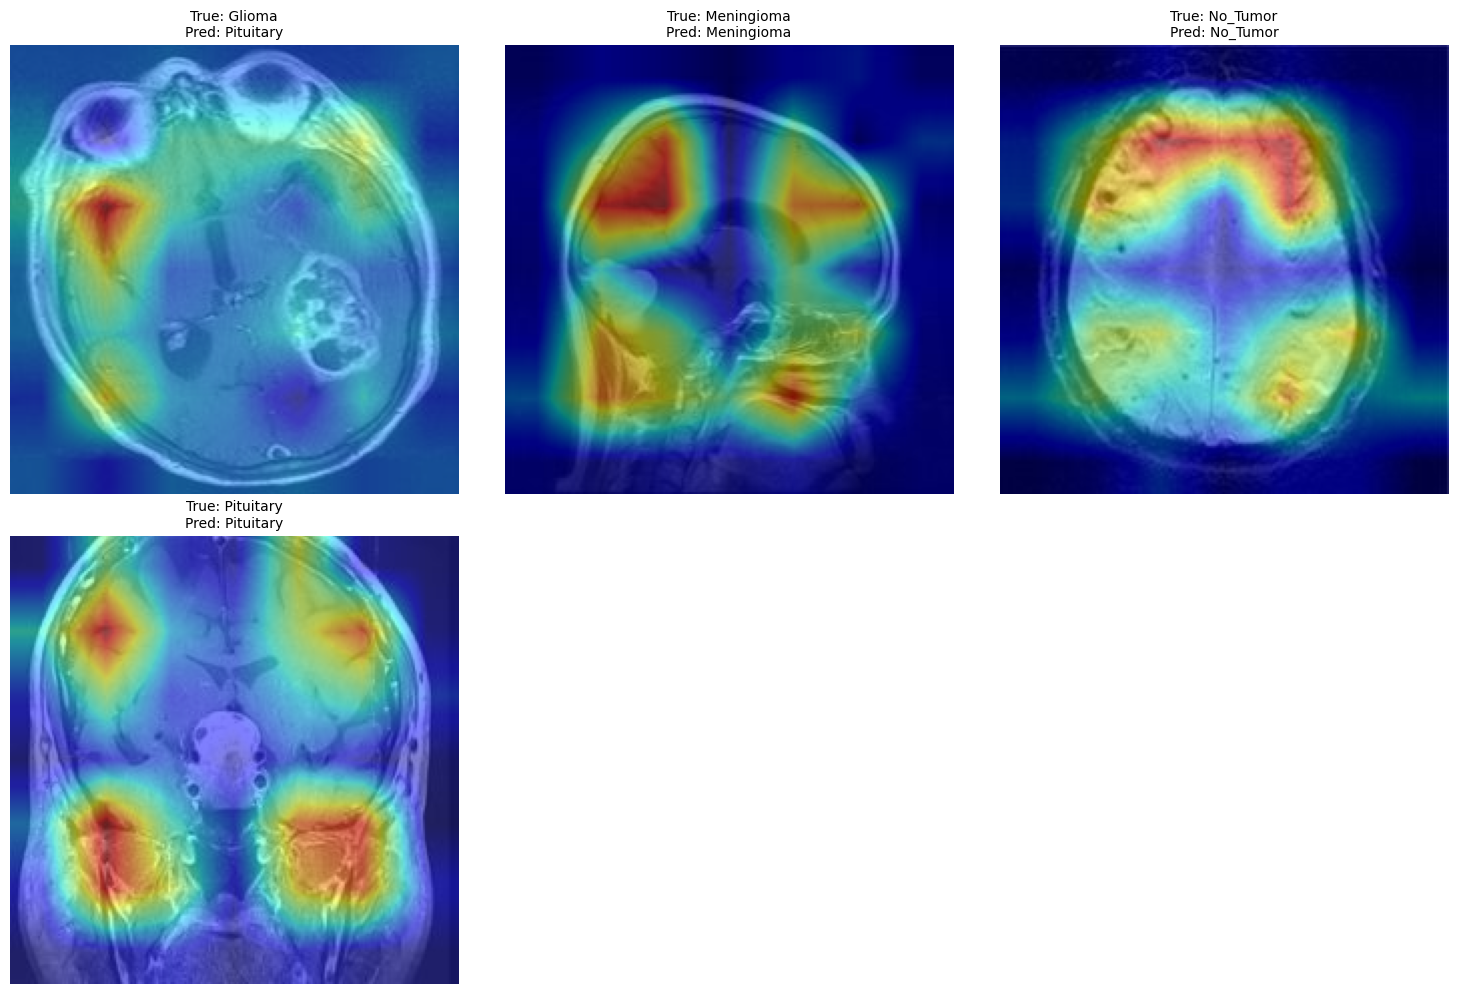

In [38]:
import os
import random
import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
image_dir = "377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing"
N = 6  # Total images to show
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Swin Transformer ===
swin_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_model.eval().to(device)

# === Transform ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Class Names ===
class_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]

# === Select diverse images ===
image_paths = []
per_class = max(1, N // len(class_names))  # e.g., if N=6, per_class=1 (or more)
random.seed(42)  # Optional for reproducibility

for class_name in class_names:
    class_folder = os.path.join(image_dir, class_name)
    img_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    selected_imgs = img_files[:per_class]  # or use random.sample(img_files, per_class) for random
    for img_file in selected_imgs:
        img_path = os.path.join(class_folder, img_file)
        image_paths.append((img_path, class_names.index(class_name)))

# Optional: if total exceeds N due to rounding
image_paths = image_paths[:N]

# === Grad-CAM function ===
def generate_gradcam(model, features, class_idx):
    features = features.unsqueeze(0)  # [1, 49, 768]
    features.requires_grad_(True)

    outputs = model(features)
    score = outputs[0, class_idx]

    model.zero_grad()
    score.backward(retain_graph=True)

    grads = features.grad
    pooled_grads = torch.mean(grads, dim=1)  # [1, 768]
    weighted_feats = features[0] * pooled_grads[0].unsqueeze(0)  # [49, 768]

    cam = torch.sum(weighted_feats, dim=1).cpu().detach().numpy()  # [49]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-5)
    return cam.reshape(7, 7), outputs.argmax(dim=1).item()

# === Grad-CAM overlay visualization (returns image) ===
def get_overlay(cam, img_pil, alpha=0.5):
    cam_resized = Image.fromarray((cam * 255).astype(np.uint8)).resize(img_pil.size, resample=Image.BILINEAR)
    cam_np = np.array(cam_resized)

    cmap = plt.get_cmap('jet')
    heatmap = cmap(cam_np / 255.0)[:, :, :3]

    img_np = np.array(img_pil).astype(np.float32) / 255.0
    overlay = heatmap * alpha + img_np * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    return overlay

# === Run and store overlays for grid ===
overlays = []
titles = []

for i, (path, label_idx) in enumerate(image_paths):
    img = Image.open(path).convert("RGB").resize((224, 224))
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        swin_out = swin_model(pixel_values=img_tensor).last_hidden_state

    model.eval()
    with torch.no_grad():
        preds = model(swin_out)

    cam, pred_idx = generate_gradcam(model, swin_out.squeeze(0), class_idx=preds.argmax(dim=1).item())

    print(f"[{i}] ✅ True: {class_names[label_idx]} | Predicted: {class_names[pred_idx]}")
    overlay = get_overlay(cam, img)
    overlays.append(overlay)
    titles.append(f"True: {class_names[label_idx]}\nPred: {class_names[pred_idx]}")

# === Display in grid (based on number of overlays we actually have) ===
num_images = len(overlays)
rows = (num_images + 2) // 3  # dynamic row count for up to 3 columns
fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axs = axs.flatten()

for i in range(num_images):
    axs[i].imshow(overlays[i])
    axs[i].set_title(titles[i], fontsize=10)
    axs[i].axis('off')

# Hide any extra axes (if grid bigger than number of images)
for j in range(num_images, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


#🔶 Part B: SHAP — Feature Attribution for TCN Output
### 🧠 Concept Recap: What is SHAP?
###SHAP (SHapley Additive exPlanations) explains the output of any ML model by assigning each feature an importance value.

###In our case, since TCN takes Swin patch embeddings as sequential input, SHAP will tell us which patches/time-steps contribute most to a prediction.

#✅ Step-by-Step Plan: SHAP on TCN

#✅ Step 1: Install SHAP Library (if not already installed)

In [ ]:
!pip install shap


#✅ Step 2: Prepare a Small Subset of Test Data

In [ ]:
#We’ll use just a few samples for SHAP due to performance
import shap
import torch
import numpy as np

# Sample 10 images from the test set
num_samples = 10
sample_images = [test_dataset[i][0] for i in range(num_samples)]
sample_labels = [test_dataset[i][1] for i in range(num_samples)]

# Send to device
inputs = torch.stack(sample_images).to(device)  # [10, 3, H, W]


#✅ Step 3: Extract Swin Features (Before TCN)

In [ ]:
with torch.no_grad():
    swin_model.eval()
    swin_features = swin_model(inputs)  # ✅ Corrected line


#✅ Step 4: Wrap the TCN Classifier for SHAP

In [ ]:
#We’ll use shap.DeepExplainer or fallback to GradientExplainer
# Set TCN to eval mode
model.eval()

# Define a forward function
def tcn_forward(x_np):
    x_tensor = torch.tensor(x_np, dtype=torch.float32).to(device)  # [B, seq_len, 768]
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


#✅ Step 5: Run SHAP Explainer

In [ ]:
explainer = shap.GradientExplainer((model, swin_features), swin_features)
shap_values = explainer.shap_values(swin_features)


AttributeError: 'SwinModelOutput' object has no attribute 'register_forward_hook'